# Stock Price Prediction using Long Short Term Memory // Machine Learning
---

- Author: Masud Rahman (https://www.masud90.github.io/)
- Dataset: Live data from Yahoo! Finance

## Initialize setup

In [3]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense,Input
from sklearn.metrics import mean_squared_error
import mplfinance as mpf

In [4]:
# Set visualization settings
sns.set_theme(context='notebook', style='whitegrid', palette='pastel')

In [5]:
# Define constants
stock_symbol = 'NVDA'
start_date = '2019-01-01'
end_date_train = '2023-12-31'
start_date_cv = '2024-01-01'
end_date_cv = '2024-06-30'
future_start_date = '2024-07-01'
future_end_date = '2024-12-31'
time_steps = 10

## Download and inspect data

In [7]:
# Download historical data till end_date_cv
data = yf.download(stock_symbol, start=start_date, end=end_date_cv)


[*********************100%%**********************]  1 of 1 completed


In [8]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,3.26600,3.46200,3.25125,3.40550,3.378611,508752000
2019-01-03,3.34475,3.37900,3.19225,3.19975,3.174486,705552000
2019-01-04,3.27350,3.44325,3.24250,3.40475,3.377867,585620000
2019-01-07,3.46250,3.62225,3.41075,3.58500,3.556694,709160000
2019-01-08,3.66725,3.66950,3.42250,3.49575,3.468149,786016000


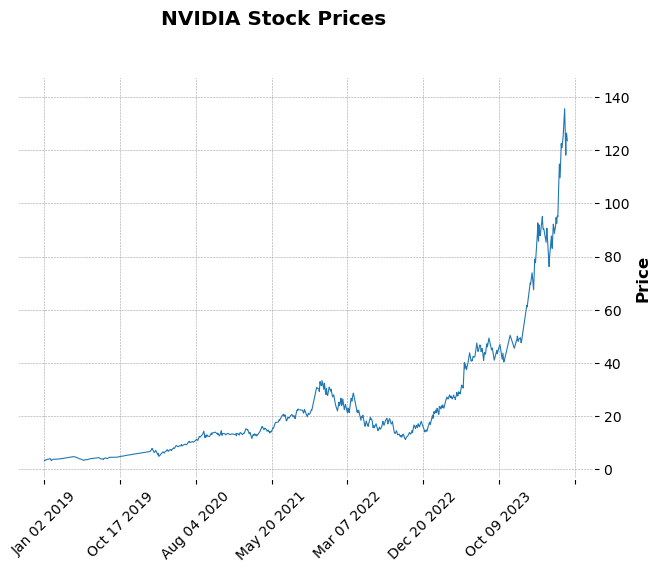

In [9]:
# Plot the NVDA data
mpf.plot(data, type='line', style='charles', title='NVIDIA Stock Prices', datetime_format='%b %d %Y')

## Data preprocessing for LSTM

In [11]:
# Data preprocessing
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices)

In [12]:
# Function to create LSTM data
def create_lstm_data(data, time_steps=1):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(x), np.array(y)

In [13]:
# Create input for LSTM for training
train_data = close_prices_scaled[:len(data[:end_date_train])]
x_train, y_train = create_lstm_data(train_data, time_steps)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Build the LSTM model

In [15]:
model = Sequential()
model.add(Input(shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

## Train the model

In [17]:
model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0102
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3384e-04
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1486e-04
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1640e-04
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0650e-04
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2260e-04
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0983e-04
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1602e-04
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0430e-04
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1807e-04
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0540e-04 
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0518e-04
Epoch 13/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4797e-05
Epoch 14/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4271e-05
Epoch 15/50
39/39 ━━━━━━━━━━━━━━

## Cross-validation

In [19]:
# Cross-validation on 2024-01-01 to 2024-06-30
cv_data = close_prices_scaled[len(data[:end_date_train]) - time_steps:len(data[:end_date_cv])]
x_cv, y_cv = create_lstm_data(cv_data, time_steps)
x_cv = np.reshape(x_cv, (x_cv.shape[0], x_cv.shape[1], 1))

In [20]:
# Predict on cross-validation data
predicted_cv_scaled = model.predict(x_cv)
predicted_cv = scaler.inverse_transform(predicted_cv_scaled)
actual_cv = scaler.inverse_transform(y_cv.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


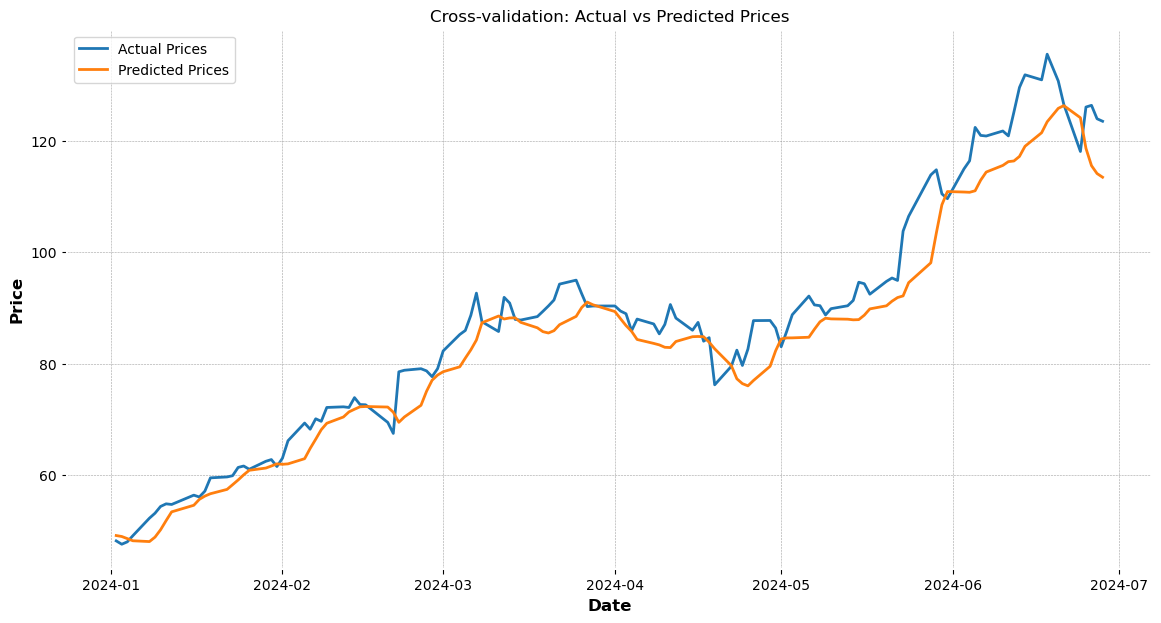

Cross-validation MSE: 29.118457687457024


In [21]:
# Calculate and visualize cross-validation performance
cv_mse = mean_squared_error(actual_cv, predicted_cv)

plt.figure(figsize=(14, 7))
plt.plot(data.index[len(data[:end_date_train]):len(data[:end_date_cv])], actual_cv, label='Actual Prices')
plt.plot(data.index[len(data[:end_date_train]):len(data[:end_date_cv])], predicted_cv,  label='Predicted Prices')
plt.title('Cross-validation: Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print(f'Cross-validation MSE: {cv_mse}')